# NEU502a
## Problem Set #3: The Drift Diffusion Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Categorical, DataFrame, concat
from scipy.stats import norm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

---
As mentioned in class, the drift-diffusion model has been a dominant model in understanding how decisions are made. The model predicts one makes a decision by integrating evidence over time. Part of the power of the driftdiffusion model is how simple it is. The dynamics are captured by:

$$ dC = v \cdot dt + w \cdot \mathcal{N}(0,1) $$

where $C$ is your decision variable, $v$ is the evidence that one is accumulating (the "drift"), and $w$ is the amount of noise in the integration (the "diffusion"). The initial condition is typically set to $C_0 = 0$ and the integration occurs to some bound $\pm B$, which initiates the choice. To get a better intuition for how the model works, we will simulate decision processes using the drift-diffusion model. 

For all of the questions, please provide one write-up with figures integrated. In addition, please submit your code alongside the writeup.

---

### The Drift Diffusion Model

In [2]:
def ddm(v, w, b=1, x0=0, dt=5e-4):
    '''Simulation of diffusion-to-bound model.
    
    Parameters
    ----------
    v : scalar
      drift rate
    w : scalar
      drift noise
    b : scalar
      boundary
    x0 : scalar
      initial evidence
    dt : scalar
      time step (in seconds)
      
    Returns
    -------
    c : int
      decision [lb = -1, ub = 1]
    z : scalar
      reaction time (in seconds)
    x : array
      evidence accumulated
    '''
    
    ## Initialize values.
    x = [x0]
    z = 0
    
    ## Drift-to-bound. 
    while np.abs(x[-1]) < b:
        x_prime = x[-1] + v * dt + w * np.random.normal(0,1)
        x.append( x_prime )
        z += dt
        
    ## Determine choice.
    if x[-1] > b: c = 1
    else: c = -1
        
    return c, z, np.array(x)

### Pre-sampling
Run at least 1000 simulations to get a good sense of how the model behaves.

**Problem 1:** Simulate a simple decision process using the drift-diffusion model. Parameters should be $C_0 = 0$, $B = 1$, $dt = 0.5$ ms, $v=2.5$, and $w=0.05$. 

**Problem 2:** If sensory evidence is increased (2x) or decreased (0.5x), how does this impact the decision process in the drift-diffusion model? Describe how you modeled a change in the sensory evidence.

**Problem 3:** Subjects appear to be able to trade accuracy for speed in most perceptual decision making tasks. The
drift-diffusion model can capture this tradeoff in a simple manner.

**Problem 4:** Using the original "baseline" model, if you examine the reaction time distributions for correct and error trials you'll notice that they are overlapping. However, in experiments, reaction times for incorrect trials are typically longer than for correct trials. To capture this effect, let’s add some more variability across trials. Instead of a fixed $v$ for all trials, allow $v$ to vary across trials according to a normal distribution: 

$$ v = 2.5 + \mathcal{N}(0, 2.5) $$

Plot the reaction time distributions for both correct and incorrect trials. Describe the distributions as in #1. Does this better capture experimental observations? Provide an intuitive explanation for why there is now an increase in reaction time for error trials. Is this biologically plausible?

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define stochastic drift function.
f = lambda: 2.5 + norm(0,2.5).rvs()

## Define sampling parameters.
n = 1000

## Define DDM parameters.
params = dict(Baseline   = dict(v=2.5,  w=0.05, b=1.0, x0=0, dt=5e-4),
              Strong     = dict(v=5.0,  w=0.05, b=1.0, x0=0, dt=5e-4),
              Weak       = dict(v=1.25, w=0.05, b=1.0, x0=0, dt=5e-4),
              Speed      = dict(v=2.5,  w=0.05, b=0.5, x0=0, dt=5e-4),
              Accuracy   = dict(v=2.5,  w=0.05, b=1.5, x0=0, dt=5e-4),
              Stochastic = dict(v=f,    w=0.05, b=1.0, x0=0, dt=5e-4) )
k = len(params)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
K = np.empty((k, n), dtype='U10')
C = np.zeros((k, n), dtype=float)
Z = np.zeros((k, n), dtype=float)
X = []

for i, kv in enumerate(params.items()):
    
    ## Extract condition and parameters.
    k, d = kv
    
    ## Iteratively simulate data.
    for j in np.arange(n):
        
        ## Sample v (if applicable.)
        if hasattr(d['v'], '__call__'): v = d['v']()
        else: v = d['v']
            
        ## Run DDM.
        c, z, x = ddm(v=v, w=d['w'], b=d['b'], dt=d['dt'], x0=d['x0'])

        ## Store values.
        K[i,j], C[i,j], Z[i,j] = k, c, z
        X.append(x)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Postprocessing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Pad drift trajectories.
Xp = np.zeros((len(X), max(len(x) for x in X)))
for i, x in enumerate(X):
    Xp[i,:len(x)] = x
    Xp[i,len(x):] = np.nan

## Save memory (unnecessary).
X = Xp.copy()
del Xp
    
## Merge data in Pandas DataFrame.
data = DataFrame(np.vstack([C.flatten(),Z.flatten()]).T, columns=('Choice','RT'))
data['Choice'] = np.where(data['Choice'] > 0, 'Correct', 'Incorrect')
data['Condition'] = K.flatten()

## Sort by RT.
sort_ix = np.argsort(data.RT.values)
data = data.loc[sort_ix].reset_index(drop=True)
X = X[sort_ix]

### Problem 1: Baseline
**a.** Plot a few (~10) model runs for both ‘correct’ and ‘incorrect’ trials. Briefly explain why the model occasionally makes decision errors.

##### Trace plots

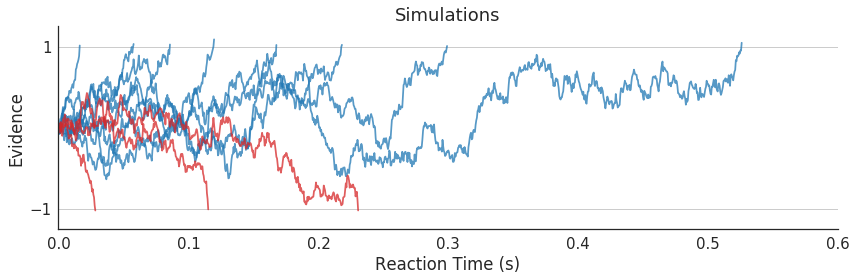

In [4]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plotting.
for choice, color in zip(['Correct','Incorrect'], ['#1f77b4', '#d62728']):
    ix, = np.where(np.logical_and(data.Condition=='Baseline', data.Choice==choice))
    ax.plot(X[ix[::100]].T, color=color, alpha=0.75)
    
## Add info.
xticks = ax.get_xticks()
ax.set(xlim=(-1), xticks=xticks, xticklabels=xticks*5e-4, xlabel='Reaction Time (s)', 
       ylim=(-1.25,1.25), yticks=[-1,1], ylabel='Evidence', title='Simulations')
ax.grid(axis='y', color='k', alpha=0.2, zorder=0)

sns.despine()
plt.tight_layout()

**Answer:** "Incorrect" reactions occur when, by choice, enough evidence is accumulated towards the "incorrect" decision so as to cross its (negative) decision threshold. 

---

**b/c.** Plot the percentage of trials that ended in "correct" and "incorrect" choices, and the reaction time distributions for "correct" and "incorrect" trials separately. 

Describe the shape of the reaction time distribution (e.g. what is the mean? the median? is it symmetric or skewed?). Relate the shape of the reaction time distribution to human/animal behavioral responses.

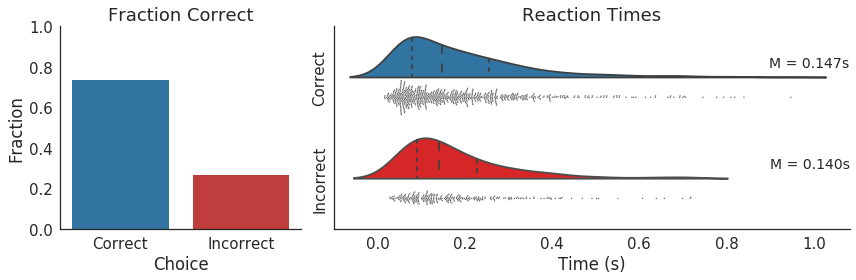

In [5]:
## Initialize canvas.
fig = plt.figure(figsize=(12,4))

## Restrict data to conditions of interest.
df = data[np.in1d(data.Condition, 'Baseline')].copy()
df.loc[df.RT > 1, 'RT'] = np.nan 
gb = df.groupby('Choice').RT.median()

## Plot percentages.
ax = plt.subplot2grid((1,3),(0,0))
sns.countplot('Choice', data=df, palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n), yticks=np.linspace(0,n,6),  ylabel='Fraction',
            yticklabels=np.linspace(0,1,6).round(1), title='Fraction Correct')

## Plot RT distribution.
ax = plt.subplot2grid((1,3),(0,1),colspan=2)
df['hue'] = Categorical(np.zeros(df.shape[0]), categories=[0,1])
sns.violinplot('RT', 'Choice', 'hue', data=df, inner='quartile', split=True, ax=ax)
df['hue'] = Categorical(np.ones(df.shape[0]), categories=[0,1])
sns.swarmplot('RT', 'Choice', 'hue', data=df, color='0.4', dodge=True, size=1.4, ax=ax)

## Add info.
ax.collections[1].set_color('#d62728')
ax.collections[1].set_edgecolor('0.3')
ax.set(xlim=(-0.1), xlabel='Time (s)', ylabel='', title='Reaction Times')
ax.set_yticklabels(['Correct','Incorrect'], rotation=90, va='center')
ax.legend_.set_visible(False)

## Add text.
ax.annotate('M = %0.3fs' %gb['Correct'], (0,0), (1,0.8), 'axes fraction', fontsize=14, ha='right')
ax.annotate('M = %0.3fs' %gb['Incorrect'], (0,0), (1,0.3), 'axes fraction', fontsize=14, ha='right')

sns.despine()
plt.tight_layout()

**Answer:** The reaction times (RT) are characteristically right-skewed; in other words, for both RT distributions (correct and incorrect) the right tail is heavier than the left tail. This is evidenced by the means of the RT distributions (correct $\approx$ 190ms and incorrect $\approx$ 180ms) being larger than the corresponding medians (correct $\approx$ 150ms and incorrect $\approx$ 140ms).

Right-skew is a characteristic feature of reaction time distributions ([Ratcliff, 1993](http://star.psy.ohio-state.edu/wp/pdf/Papers/psybull93a.pdf); [Ratcliff et al., 1999](http://star.psy.ohio-state.edu/html/wp/pdf/psychrev99.pdf)). Psychologically, the bias towards slower responses likely reflects effects of attention and motivation where it is difficult to consistently maintain higher levels of cognitive effort (i.e. low RTs). From the perspective of the drift diffusion model, the right-skew bias can be explained purely probabilistically: diffusion paths comprised of a series of strongly positive steps constitute occupy a smaller portion of probability space than all other paths. 

---

### Problem 2

When sensory evidence is increased, the rate of evidence accumulation should increase leading to an in increase in correct choices and decreased reaction times (especially reduced tails). When sensory evidence is decreased, the rate of evidence accumulation should decrease leading to an in decrease in correct choices and increased reaction times. 

This can be modeled by increasing the drift rate. Psychologically, changing the drift rate may reflect one of two processes. It may reflect an increase in the instructive value of evidence from the environment (e.g. improved brightness or acuity of visual info). Alternately increasing the drift rate may reflect an increase in the motivation or attentional resources allocated to evidence accumulation, which neurally acts as if external evidence were improved. 

---

**b.** As for #1, plot a few model runs, the percent of correct/incorrect, and the reaction time distributions for all three levels of sensory evidence (baseline, increased, and decreased)

##### Trace plots

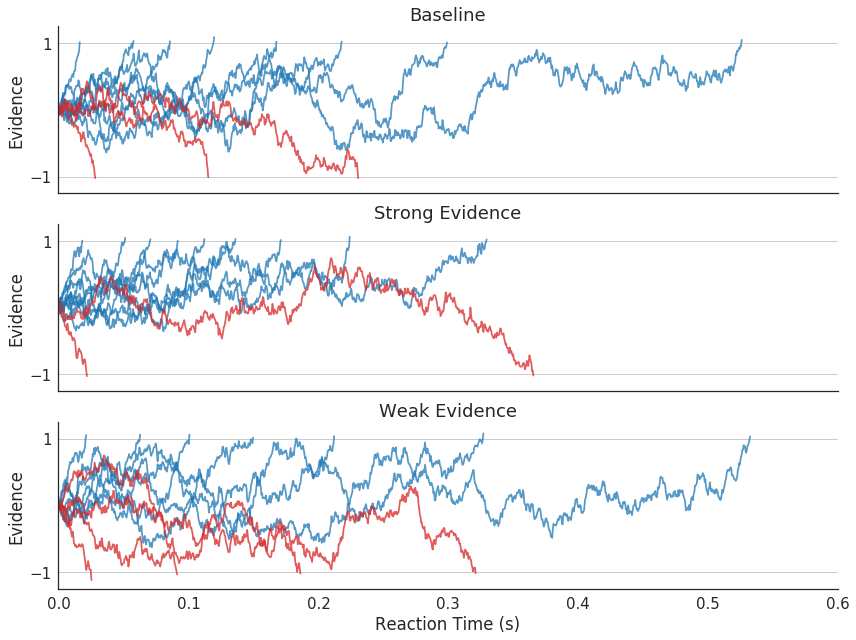

In [6]:
## Initialize canvas.
fig, axes = plt.subplots(3,1,figsize=(12,9),sharex=True, sharey=True)

for ax, condition in zip(axes, ['Baseline','Strong','Weak']):
    
    ## Plotting.
    for choice, color in zip(['Correct','Incorrect'], ['#1f77b4', '#d62728']):
        ix, = np.where(np.logical_and(data.Condition==condition, data.Choice==choice))
        ax.plot(X[ix[::100]].T, color=color, alpha=0.75)

    ## Add info.
    xticks = ax.get_xticks()
    title = '%s Evidence' %condition if not condition == 'Baseline' else condition
    ax.set(xlim=(-1), xticks=xticks, xticklabels=xticks*5e-4,  ylim=(-1.25,1.25), 
           yticks=[-1,1], ylabel='Evidence', title=title)
    ax.grid(axis='y', color='k', alpha=0.2, zorder=0)

ax.set_xlabel('Reaction Time (s)')
sns.despine()
plt.tight_layout()

##### Proportion of Choices

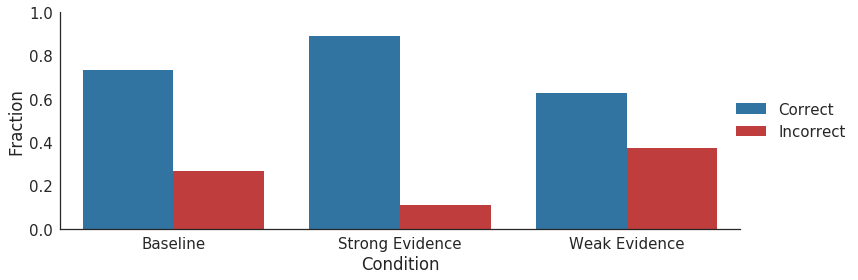

In [7]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Restrict data to conditions of interest.
df = data[np.in1d(data.Condition, ['Baseline','Strong','Weak'])].copy()
df.loc[df.RT > 1, 'RT'] = np.nan 

## Plot.
sns.countplot('Condition', hue='Choice', data=df, 
              palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n), xticklabels=['Baseline','Strong Evidence','Weak Evidence'],
       yticks=np.linspace(0,n,6), yticklabels=np.linspace(0,1,6).round(1), ylabel='Fraction')
ax.legend(loc=7, bbox_to_anchor=(1.175,0.5))

sns.despine()
plt.tight_layout()

##### Reaction Times

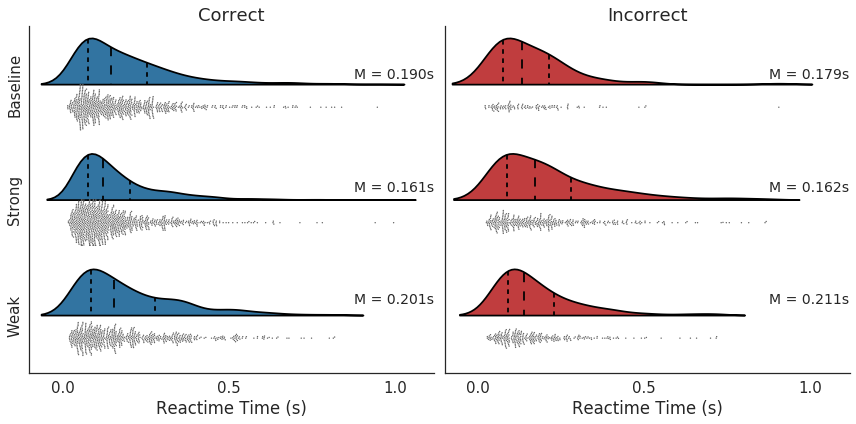

In [8]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=True)

gb = df.groupby(['Choice','Condition']).RT.mean()
for ax, choice, color in zip(axes, ['Correct','Incorrect'], ['#1f77b4', '#d62728']):

    ## Plot RT distribution.
    df['hue'] = Categorical(np.zeros(df.shape[0]), categories=[0,1])
    sns.violinplot('RT', 'Condition', 'hue', data=df[df.Choice==choice], 
                   palette=[color,'k'], alpha=1, inner='quartile', split=True, ax=ax)
    df['hue'] = Categorical(np.ones(df.shape[0]), categories=[0,1])
    sns.swarmplot('RT', 'Condition', 'hue', data=df[df.Choice==choice], 
                  color='0.4', dodge=True, size=1.4, ax=ax)

    ## Add info.
    ax.set(xlim=(-0.1), xticks=np.linspace(0,1,3), xlabel='Reactime Time (s)', 
           ylabel='', title=choice)
    ax.set_yticklabels(['Baseline','Strong','Weak'], rotation=90, va='center')
    ax.legend_.set_visible(False)
    
    ## Add text.
    for y, condition in zip([0.85,0.525,0.2], ['Baseline','Strong','Weak']):
        ax.annotate('M = %0.3fs' %gb[choice,condition], (0,0), (1,y), 
                    'axes fraction', fontsize=14, ha='right')

sns.despine()
plt.tight_layout()

### Problem 3


**a.** Describe how you modeled the accuracy/speed tradeoff. Why is this a biologically plausible way of capturing this effect?

**FIND REFS**

---

**b.** Again, as in #1, plot a few model runs, the percent of correct/incorrect, and the reaction time distributions for your baseline model, an "accurate" biased model, and a "speed" biased model.

##### Trace plots

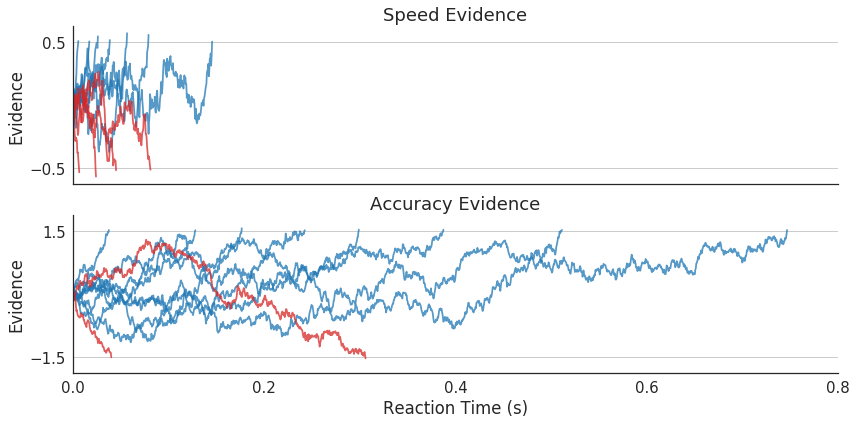

In [9]:
## Initialize canvas.
fig, axes = plt.subplots(2,1,figsize=(12,6), sharex=True)

for ax, condition, b in zip(axes, ['Speed', 'Accuracy'], [0.5, 1.5]):
    
    ## Plotting.
    for choice, color in zip(['Correct','Incorrect'], ['#1f77b4', '#d62728']):
        ix, = np.where(np.logical_and(data.Condition==condition, data.Choice==choice))
        ax.plot(X[ix[::100]].T, color=color, alpha=0.75)

    ## Add info.
    xticks = np.linspace(0,1600,5)
    title = '%s Evidence' %condition if not condition == 'Baseline' else condition
    ax.set(xlim=(-1), xticks=xticks, xticklabels=xticks*5e-4, ylim=(-b*1.25, b*1.25), 
           yticks=[-b,b], ylabel='Evidence', title=title)
    ax.grid(axis='y', color='k', alpha=0.2, zorder=0)

ax.set_xlabel('Reaction Time (s)')
sns.despine()
plt.tight_layout()

##### Proportion of Choices

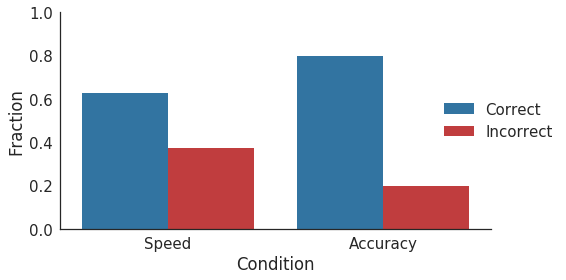

In [10]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Restrict data to conditions of interest.
df = data[np.in1d(data.Condition, ['Speed', 'Accuracy'])].copy()
df.loc[df.RT > 1, 'RT'] = np.nan 

## Plot.
sns.countplot('Condition', hue='Choice', data=df, 
              palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n), yticks=np.linspace(0,n,6), ylabel='Fraction',
       yticklabels=np.linspace(0,1,6).round(1))
ax.legend(loc=7, bbox_to_anchor=(1.175,0.5))

sns.despine()
plt.tight_layout()

##### Reaction Times

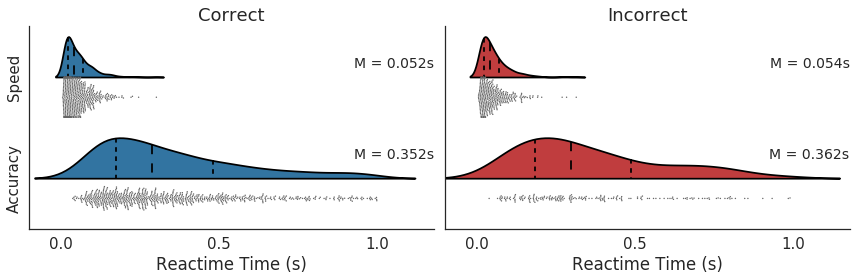

In [11]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,4),sharex=True,sharey=True)

gb = df.groupby(['Choice','Condition']).RT.mean()
for ax, choice, color in zip(axes, ['Correct','Incorrect'], ['#1f77b4', '#d62728']):

    ## Plot RT distribution.
    df['hue'] = Categorical(np.zeros(df.shape[0]), categories=[0,1])
    sns.violinplot('RT', 'Condition', 'hue', data=df[df.Choice==choice], 
                   palette=[color,'k'], alpha=1, inner='quartile', split=True, ax=ax)
    df['hue'] = Categorical(np.ones(df.shape[0]), categories=[0,1])
    sns.swarmplot('RT', 'Condition', 'hue', data=df[df.Choice==choice], 
                  color='0.4', dodge=True, size=1.4, ax=ax)

    ## Add info.
    ax.set(xlim=(-0.1), xticks=np.linspace(0,1,3), xlabel='Reactime Time (s)', 
           ylabel='', title=choice)
    ax.set_yticklabels(['Speed','Accuracy'], rotation=90, va='center')
    ax.legend_.set_visible(False)
    
    ## Add text.
    for y, condition in zip([0.80,0.35], ['Speed','Accuracy']):
        ax.annotate('M = %0.3fs' %gb[choice,condition], (0,0), (1,y), 
                    'axes fraction', fontsize=14, ha='right')

sns.despine()
plt.tight_layout()

### Problem 4
Using the original "baseline" model, if you examine the reaction time distributions for correct and error
trials you'll notice that they are overlapping. However, in experiments, reaction times for incorrect trials are typically longer than for correct trials. To capture this effect, let’s add some more variability across trials. Instead of a fixed $v$ for all trials, allow $v$ to vary across trials according to a normal distribution: 

$$ v = 2.5 + \mathcal{N}(0, 2.5) $$

Plot the reaction time distributions for both correct and incorrect trials. Describe the distributions as in #1. Does this better capture experimental observations? Provide an intuitive explanation for why there is now an increase in reaction time for error trials. Is this biologically plausible?

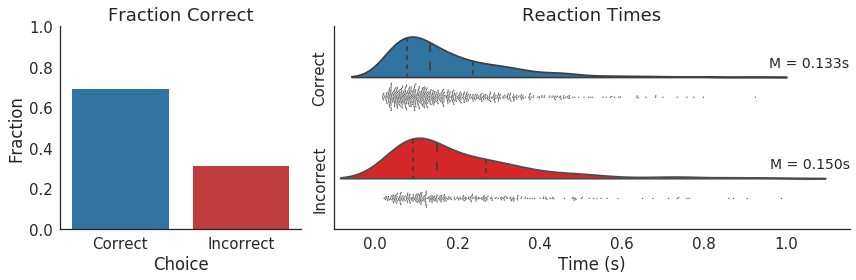

In [12]:
from scipy.stats import ttest_ind

## Initialize canvas.
fig = plt.figure(figsize=(12,4))

## Restrict data to conditions of interest.
df = data[np.in1d(data.Condition, 'Stochastic')].copy()

## Perform 2-sample t-test.
t, p = ttest_ind(data.loc[data.Choice=='Correct', 'RT'],
                 data.loc[data.Choice=='Incorrect', 'RT'])

df.loc[df.RT > 1, 'RT'] = np.nan 
gb = df.groupby('Choice').RT.median()

## Plot percentages.
ax = plt.subplot2grid((1,3),(0,0))
sns.countplot('Choice', data=df, palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n), yticks=np.linspace(0,n,6),  ylabel='Fraction',
            yticklabels=np.linspace(0,1,6).round(1), title='Fraction Correct')

## Plot RT distribution.
ax = plt.subplot2grid((1,3),(0,1),colspan=2)
df['hue'] = Categorical(np.zeros(df.shape[0]), categories=[0,1])
sns.violinplot('RT', 'Choice', 'hue', data=df, inner='quartile', split=True, ax=ax)
df['hue'] = Categorical(np.ones(df.shape[0]), categories=[0,1])
sns.swarmplot('RT', 'Choice', 'hue', data=df, color='0.4', dodge=True, size=1.4, ax=ax)

## Add info.
ax.collections[1].set_color('#d62728')
ax.collections[1].set_edgecolor('0.3')
ax.set(xlim=(-0.1), xlabel='Time (s)', ylabel='', title='Reaction Times')
ax.set_yticklabels(['Correct','Incorrect'], rotation=90, va='center')
ax.legend_.set_visible(False)

## Add text.
ax.annotate('M = %0.3fs' %gb['Correct'], (0,0), (1,0.8), 'axes fraction', fontsize=14, ha='right')
ax.annotate('M = %0.3fs' %gb['Incorrect'], (0,0), (1,0.3), 'axes fraction', fontsize=14, ha='right')

sns.despine()
plt.tight_layout()

**Answer:** Because now, for some trials, evidence accumulation may be overtaken by noise. But positive drift will mean that it will take longer for drift to reach negative bound. 

In [13]:
print('RT(Correct - Incorrect): t = %0.3f, p = %0.3f' %(t,p))

RT(Correct - Incorrect): t = 2.244, p = 0.025


Totally plausible given cholinergic circuitry. See Cohen & Aston-Jones (2005).